In [1]:
from lumberjack_tools import *
from lumberjack_trading  import *

Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1
TaLib version  0.4.19
FinTA version  1.3
Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1


## PARAMETRES

In [32]:
x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2018-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 55
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 0
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 1
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0

## Chargement de la base, K-Lines, Application de stratégie (=> Signal)

In [33]:
%%time
df = joblib.load('BASES/EURUSD_m5')
df = convert32(df)
df = klines(df)
df = strategy(df)
print(df.Signal.value_counts())

 0    784235
 1     18425
-1     18247
Name: Signal, dtype: int64
CPU times: user 1.09 s, sys: 658 ms, total: 1.75 s
Wall time: 1.83 s


## Purification du signal sur train + test (de _strat à _stop)

In [34]:
%%time
_nb_looser = 10000000000
TRACKER = []
_year_bottom = _start
_year_top = _stop
_verbose = 0
print()
print(col.Fore.CYAN,'TRAIN/TEST WITHOUT AI',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)


print()
print(col.Fore.BLUE,'DENOISING & ENHANCING',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
    df['Valid'] = np.where(((df.Signal!=0)&(df.TRACKER==1)),1,0)
    df['Signal'] = np.where(((df.Valid==1)&(df.Signal==1)),1,np.where(((df.Valid==1)&(df.Signal==-1)),-1,0))
    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print('Shape de features',df.shape)
joblib.dump(df,'BASES/df_denoz_EURUSD_m5')
joblib.dump(TRACKER,'BASES/TRACKER')



 TRAIN/TEST WITHOUT AI 
Début des opérations horodatée à 2021-06-02 00:19:55.569693
_trigger_rsi : 0
100%|██████████| 546188/546188 [00:39<00:00, 13784.84it/s]
BT's execution time 0:00:46.293407
 Total Number of trades 8169 
 PROFIT FACTOR :  0.96 
 Winners Ratio : 51.16 % 
_bt_report : 0

 DENOISING & ENHANCING 
Début des opérations horodatée à 2021-06-02 00:20:45.548607
_trigger_rsi : 0
100%|██████████| 546188/546188 [00:24<00:00, 22109.91it/s]
BT's execution time 0:00:31.362352
 Total Number of trades 4178 
 PROFIT FACTOR :  inf 
 Winners Ratio : 100.0 % 
_bt_report : 0
Shape de features (820907, 66)
CPU times: user 1min 5s, sys: 923 ms, total: 1min 6s
Wall time: 1min 25s


['BASES/TRACKER']

## CHargement de la base débruitée

In [57]:
df = joblib.load('BASES/EURUSD_m5')
df = convert32(df)
df = klines(df)
df = strategy(df)

## Features Transformation

In [58]:
%%time
#df = df[['Open','High','Low','Close','Body','UpperShadow','LowerShadow','Color','Valid','TRACKER','Signal']]
df = exotic_indicators(df)
df = df.dropna()
df.shape

CPU times: user 21 s, sys: 296 ms, total: 21.3 s
Wall time: 21.1 s


(714845, 81)

4

In [59]:
%%time
COLUMNS = ['Valid','TRACKER','Signal']
# Transformation par les inverse, carré, cos, sin, log et tan
df = feature_transformation(df,COLUMNS)

df.shape

CPU times: user 8.47 s, sys: 4.11 s, total: 12.6 s
Wall time: 12.5 s


(714845, 527)

In [60]:
%%time
# Colonnes non traitées
COLUMNS = ['Valid','TRACKER','Signal']

# différences sur 1, 2, 3, 4 et 5 bougies
_factor = 2
df = feature_diff(df,COLUMNS,_factor)

df.shape

CPU times: user 25.9 s, sys: 20.7 s, total: 46.6 s
Wall time: 45.8 s


(714844, 1053)

In [61]:
joblib.dump(df,'BASES/df_inter_EURUSD_m5')

['BASES/df_inter_EURUSD_m5']

In [62]:
%%time
# On repart de la base originale, opur réavoir tous les signaux
df = joblib.load('BASES/df_inter_EURUSD_m5')
TRACKER = joblib.load('BASES/TRACKER')

# On réapplique Strategy pour ré-avoir tous les signaux gagnants et non gagnants
df = strategy(df)

CPU times: user 6.52 s, sys: 7.32 s, total: 13.8 s
Wall time: 13.8 s


In [63]:
df.shape

(714844, 1053)

## Préparation de df et sauvgarde de df_raw

In [64]:
%%time
# On récupère les dates des bons signaux, et on assigne 1 si le signal était gagnant
df['Valid'] = np.where(df.index.isin(TRACKER),1,0)
# On assigne 1 si Signal + Valid et 2 si Signal + non valid
df = make_valid(df)
df.Valid.value_counts(),df.Signal.value_counts()

CPU times: user 53.7 ms, sys: 9.45 ms, total: 63.2 ms
Wall time: 56.5 ms


(0    682899
 2     27767
 1      4178
 Name: Valid, dtype: int64,
  0    682899
  1     16006
 -1     15939
 Name: Signal, dtype: int64)

In [65]:
%%time

# On met de côté cette dataframe avec df_raw
df_raw = df.copy()

# On réduit la base à une base n'ayant que des signaux gagnants et non gagnants (issus de Strategy)
df_long = df[df.Signal == 1].copy()
print('Après réduction des longs \n',df_long.Valid.value_counts())
df_short = df[df.Signal == -1].copy()
print('Après réduction des shorts \n',df_short.Valid.value_counts(),'\n')
# Si on a un Signal à 1 ou -1 et que c'était un signal gagnant, on met Valid à 1, sinon à 2
df_long = make_valid(df_long)
df_short = make_valid(df_short)

# Répartition de la classe Valid
print('\nPour les longs après make valid: \n',df_long.Valid.value_counts())
print('Pour les short après make valid: \n',df_short.Valid.value_counts(),'\n')

print('\nPour les longs, vérif Signal : \n',df_long.Signal.value_counts())
print('Pour les short, vérif Signal : \n',df_short.Signal.value_counts(),'\n')

# Sauvegarde de df en df_prep et de df_raw
joblib.dump(df_long,'BASES/df_long_prep_EURUSD_m5')
joblib.dump(df_short,'BASES/df_short_prep_EURUSD_m5')
joblib.dump(df_raw,'BASES/df_raw_EURUSD_m5')


Après réduction des longs 
 2    13851
1     2155
Name: Valid, dtype: int64
Après réduction des shorts 
 2    13916
1     2023
Name: Valid, dtype: int64 


Pour les longs après make valid: 
 0    13851
1     2155
Name: Valid, dtype: int64
Pour les short après make valid: 
 0    13916
1     2023
Name: Valid, dtype: int64 


Pour les longs, vérif Signal : 
 1    16006
Name: Signal, dtype: int64
Pour les short, vérif Signal : 
 -1    15939
Name: Signal, dtype: int64 

CPU times: user 4.36 s, sys: 5.37 s, total: 9.74 s
Wall time: 10.5 s


['BASES/df_raw_EURUSD_m5']

## Début Base déjà préparée

In [66]:
%%time
df_long = joblib.load('BASES/df_long_prep_EURUSD_m5')
df_short = joblib.load('BASES/df_short_prep_EURUSD_m5')
df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df_long.shape,df_short.shape

CPU times: user 3.23 s, sys: 4.93 s, total: 8.16 s
Wall time: 8.34 s


((16006, 1054), (15939, 1054))

## Split des jeux d'entrainement et mise à l'échelle LONG

In [67]:
%%time
# Séparation en jeux d'entrainement, de test et séparation du jeu out of sample
df_train, df_test, df_oos = split_df(df_long,_start,_mid,_stop,_last)

# Colonnes mises en exception pour le passage à l'échelle
EXCEPTION = ['Signal', 'Color', 'Valid','TRACKER']

# Choix du scaler
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MaxAbsScaler()


# Mise à l'échelle
df_train = feature_scaling(df_train,scaler,EXCEPTION)
df_test = feature_scaling(df_test,scaler,EXCEPTION)
df_oos = feature_scaling(df_oos,scaler,EXCEPTION)

# Sauvegarde des jeux de données
joblib.dump(df_train,'BASES/train_EURUSD_m5')
joblib.dump(df_test,'BASES/test_EURUSD_m5')
joblib.dump(df_oos,'BASES/oos_EURUSD_m5')

CPU times: user 1.26 s, sys: 346 ms, total: 1.61 s
Wall time: 1.75 s


['BASES/oos_EURUSD_m5']

## Début avec jeu de données séparées

In [68]:
%%time
df_train = joblib.load('BASES/train_EURUSD_m5')
df_test = joblib.load('BASES/test_EURUSD_m5') 
df_oos = joblib.load('BASES/oos_EURUSD_m5') 

CPU times: user 51 ms, sys: 48.1 ms, total: 99.1 ms
Wall time: 98.9 ms


In [69]:
df_train.Signal.value_counts(), df_train.Valid.value_counts()

(1    8043
 Name: Signal, dtype: int64,
 0    6564
 1    1479
 Name: Valid, dtype: int64)

In [70]:
%%time
# Remplacement des 2 de Valid par un 0
#df_train['Valid'] = np.where(df_train.Valid==2,0,1)#df_train.Valid)#.reshape(-1,1)
#df_test['Valid'] = np.where(df_test.Valid==2,0,1)#df_test.Valid)#.reshape(-1,1)
print(df_train.Valid.value_counts())

# Undesmapling
df_train = undersample2(df_train,'Valid')

# Oversampling
#df_train = oversample2(df_train,'Valid')

# Séparation des X et des y
y_train = df_train.Valid
y_test = df_test.Valid
X_train = df_train.drop(['Valid','Signal'],axis=1)
X_test = df_test.drop(['Valid','Signal'],axis=1)


0    6564
1    1479
Name: Valid, dtype: int64
Avant Resampling :
Classe 0 6564
Classe 1 1479

Après resample:
Classe 0 1479
Classe 1 1479
CPU times: user 95.9 ms, sys: 23.8 ms, total: 120 ms
Wall time: 118 ms


## Feature Selection

R2_Score :  -0.8106287583881653
Mean Absolute Error 0.4258106139456761
ok
CPU times: user 615 ms, sys: 10.8 ms, total: 625 ms
Wall time: 628 ms


((2958, 15), (4146, 15))

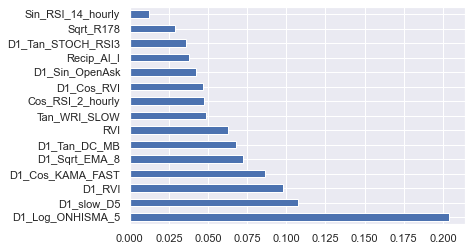

In [71]:
%%time
# Si selection en Univariate
#X_train, X_test = univariate_feature_selection(X_train, X_test, y_train, _k=6,_send=0)

# Si Selection par lasso
#lasso_feature_selection(X_train,X_test,y_train,y_test,_send=0)

# RF Method
X_train, X_test, selected_columns = rf_feature_selection(X_train,X_test,y_train,y_test,n=15,_send=1)

# Si selection par l1
#X_train, X_test = l1_feature_selection(X_train, X_test, y_train, _C=1,_send=0)

joblib.dump(X_train,'BASES/X_train.dag')
joblib.dump(X_test,'BASES/X_test.dag')

# Vérification des shapes
X_train.shape, X_test.shape

In [72]:
X_train = X_train[selected_columns[selected_columns>0].keys()]
X_test = X_test[selected_columns[selected_columns>0].keys()]

In [73]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2958 entries, 2011-06-20 04:45:00 to 2016-06-29 01:25:00
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   D1_Log_ONHISMA_5   2958 non-null   float64
 1   D1_slow_D5         2958 non-null   float64
 2   D1_RVI             2958 non-null   float64
 3   D1_Cos_KAMA_FAST   2958 non-null   float64
 4   D1_Sqrt_EMA_8      2958 non-null   float64
 5   D1_Tan_DC_MB       2958 non-null   float64
 6   RVI                2958 non-null   float64
 7   Tan_WRI_SLOW       2958 non-null   float64
 8   Cos_RSI_2_hourly   2958 non-null   float64
 9   D1_Cos_RVI         2958 non-null   float64
 10  D1_Sin_OpenAsk     2958 non-null   float64
 11  Recip_AI_I         2958 non-null   float64
 12  D1_Tan_STOCH_RSI3  2958 non-null   float64
 13  Sqrt_R178          2958 non-null   float64
 14  Sin_RSI_14_hourly  2958 non-null   float64
dtypes: float64(15)
memory usage: 369.8 K

# CHARGEMENT XTRAIN ET XTEST L1
X_train = joblib.load('BASES/X_train.dag')
X_test = joblib.load('BASES/X_test.dag')

## Entrainement

In [74]:
%%time
# Affectatioon de poids différents en fonction des clases
class_weight = affect_weight(y_train)
BATCH_SIZE = 320
# Construction du modèle
_first_a = 'relu'
_a='relu'
_last_a='sigmoid'
model = make_model(X_train, _first_a, _a, _last_a, BATCH_SIZE)

# Compilation du modèlé
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True,) # (monitor='val_prc', verbose=1, patience=20, mode='max', restore_best_weights=True)

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = compile_model(model,METRICS=METRICS)



Initial bias [0.]

Weight for class 0: 1.00
Weight for class 1: 1.00
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 63)                1008      
_________________________________________________________________
dropout (Dropout)            (None, 63)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_____________________________________________________

## Evaluation du meilleur Batch

In [75]:
%%time
# Evaluation du meilleur batch
_borne = int(X_train.shape[0])
_step = 100
BATCH_SIZE = evaluate_batch(model, X_train, y_train,_borne,_step)

100%|██████████| 30/30 [00:01<00:00, 23.97it/s]Meilleur Loss: 0.6932
Meilleur Batch: 2710.0000
CPU times: user 1.76 s, sys: 554 ms, total: 2.31 s
Wall time: 1.25 s



## Fit the model

Batch retenu 2710
Train on 2958 samples, validate on 4146 samples
Epoch 1/200
2958/2958 [==============================] - 1s 186us/sample - loss: 0.6939 - accuracy: 0.5118 - precision: 0.5106 - recall: 0.5713 - auc: 0.5015 - prc: 0.4964 - val_loss: 0.6988 - val_accuracy: 0.2132 - val_precision: 0.1613 - val_recall: 0.9112 - val_auc: 0.4930 - val_prc: 0.1609
Epoch 2/200
2958/2958 [==============================] - 0s 87us/sample - loss: 0.6936 - accuracy: 0.5034 - precision: 0.5033 - recall: 0.5213 - auc: 0.5029 - prc: 0.5055 - val_loss: 0.6975 - val_accuracy: 0.1630 - val_precision: 0.1630 - val_recall: 1.0000 - val_auc: 0.4823 - val_prc: 0.1579
Epoch 3/200
2958/2958 [==============================] - 0s 85us/sample - loss: 0.6937 - accuracy: 0.4932 - precision: 0.4891 - recall: 0.3029 - auc: 0.4844 - prc: 0.4877 - val_loss: 0.6902 - val_accuracy: 0.8370 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.1630
Epoch 4/200
2958/2958 [====================

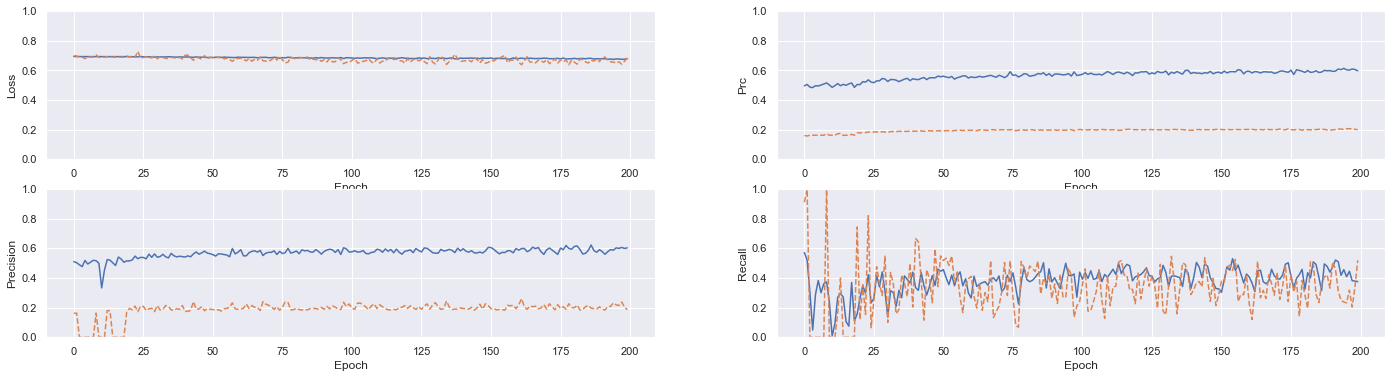

In [76]:

epochs=200
#BATCH_SIZE = 2810
print('Batch retenu',BATCH_SIZE)
history = fit_model(X_train,y_train,X_test,y_test,model,epochs=epochs,callbacks=None,class_weight=class_weight)

## Predictions de yhat et attribution des étiquettes

In [77]:
%%time
ytest, yhat = norm_target(model,X_test,y_test)

100%|██████████| 4146/4146 [00:00<00:00, 262053.14it/s]CPU times: user 335 ms, sys: 77.2 ms, total: 412 ms
Wall time: 253 ms



## Obtention des résultats du training

Signaux - Accuracy : 83.53 %
Signaux - Precision : 33.33 %
Signaux - Recall : 1.04 %
Achat - F-measure: : 2.01 %


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3470
           1       0.33      0.01      0.02       676

    accuracy                           0.84      4146
   macro avg       0.59      0.50      0.47      4146
weighted avg       0.76      0.84      0.76      4146

         Positifs Négatifs
Positifs        7      669
Négatifs       14     3456

Vrais signaux positifs trouvés    :  7
Vrais signaux positifs non trouvé : 669
Total des signaux posistifs : 676
 Précision : 33.33 % 
 Recall : 1.04 % 
 F-Score : 2.02 % 


Vrais signaux négatifs trouvés    :  3456
Vrais signaux négatifs non trouvé : 14
Total des signaux négatifs : 3470
 Précision : 83.78 % 
 Recall : 99.6 % 
 F-Score : 91.01 % 


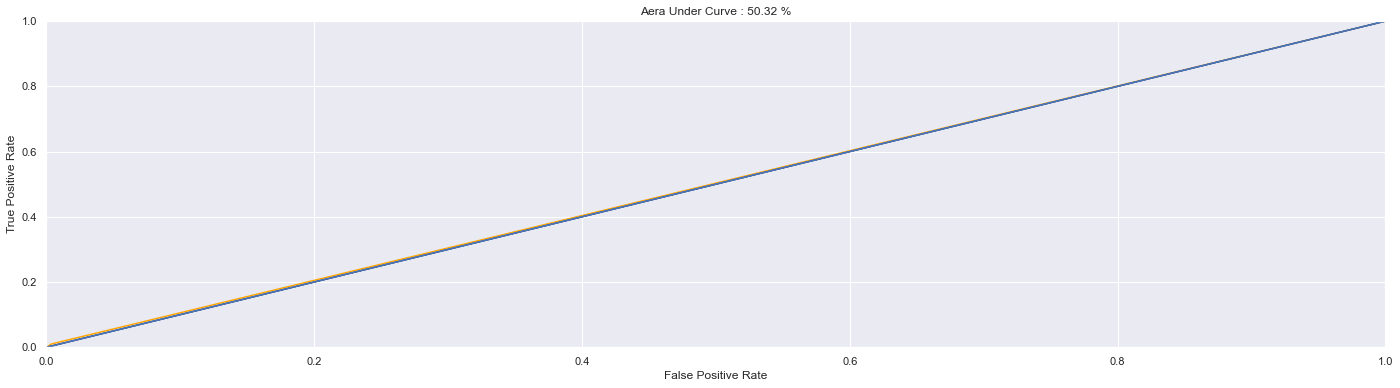

In [78]:
get_results(y_test,yhat)

## Sauvegarde du model

In [79]:
model.save('MODELS/Long')

INFO:tensorflow:Assets written to: MODELS/Long/assets


model = model.load_model('MODELS/Essais')

## Test on OOS

In [96]:
for t in selected_columns[selected_columns>0].keys():
    print(t)

D1_Log_ONHISMA_5
D1_slow_D5
D1_RVI
D1_Cos_KAMA_FAST
D1_Sqrt_EMA_8
D1_Tan_DC_MB
RVI
Tan_WRI_SLOW
Cos_RSI_2_hourly
D1_Cos_RVI
D1_Sin_OpenAsk
Recip_AI_I
D1_Tan_STOCH_RSI3
Sqrt_R178
Sin_RSI_14_hourly


In [101]:
%%time
# Colonnes non traitées
COLUMNS = []

# Colonnes mises en exception pour le passage à l'échelle
EXCEPTION = ['Signal', 'Color', 'Valid']

_factor=2

df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df_raw = strategy(df_raw)

_, _, oos = split_df(df_raw.drop(['Valid','Signal'],axis=1),_start, _mid, _stop, _last)
oos = strategy(oos)
oos = oos.dropna()

# Long only
oos['Signal'] = np.where(oos.Signal==1,1,0)

# Chargement des indicateurs exotiques
oos = exotic_indicators(oos)

#oos = oos[['ONHISMA_5','slow_D5' ,'RVI','KAMA_FAST','EMA_8','DC_MB','WRI_SLOW','RSI_2_hourly','OpenAsk' ,'AI_I','STOCH_RSI3','R178','RSI_14_hourly']]


# Transformation par les inverse, carré, cos, sin, log et tan
oos = feature_transformation(oos,COLUMNS)

# différences sur 1, 2, 3, 4 et 5 bougies
oos = feature_diff(oos,COLUMNS,_factor)

# Restriction de oos aux colonnes qui ont servi au DL
oos = oos[selected_columns[selected_columns>0].keys()]

# Choix du scaler()
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MaxAbsScaler()
#scaler = MinMaxScaler()

# Mise à l'échelle
oos = feature_scaling(oos,scaler,EXCEPTION)

# Séparation des X et des y
X_oos = oos.copy()

colfilter = X_test.columns.to_list()
colfilter.append('Signal')

X_oos1 = X_oos[colfilter].copy()

In [98]:
oos

,ONHISMA_5,slow_D5,RVI,EMA_8,RSI_2_hourly,OpenAsk,R178,RSI_14_hourly,Log_ONHISMA_5,Sqrt_ONHISMA_5,...,D3_Cos_RSI_14_hourly,D4_Cos_RSI_14_hourly,D1_Sin_RSI_14_hourly,D2_Sin_RSI_14_hourly,D3_Sin_RSI_14_hourly,D4_Sin_RSI_14_hourly,D1_Tan_RSI_14_hourly,D2_Tan_RSI_14_hourly,D3_Tan_RSI_14_hourly,D4_Tan_RSI_14_hourly
2018-12-31 00:50:00,1.144762,82.615845,63.520573,1.144592,63.620140,1.14482,1.171227,50.802711,0.135197,1.069936,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-31 00:55:00,1.144890,77.032799,58.521900,1.144614,63.620140,1.14477,1.171227,50.802711,0.135309,1.069995,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-31 01:00:00,1.144869,58.697399,54.246788,1.144586,92.886192,1.14477,1.171227,53.156403,0.135290,1.069985,...,-1.827876,-1.827876,-0.263702,-0.263702,-0.263702,-0.263702,-0.851728,-0.851728,-0.851728,-0.851728
2018-12-31 01:05:00,1.144773,36.647083,50.315319,1.144549,92.886192,1.14457,1.171227,53.156403,0.135206,1.069941,...,-1.827876,-1.827876,0.000000,-0.263702,-0.263702,-0.263702,0.000000,-0.851728,-0.851728,-0.851728
2018-12-31 01:10:00,1.144655,19.711475,53.919495,1.144500,92.886192,1.14450,1.171227,53.156403,0.135103,1.069886,...,-1.827876,-1.827876,0.000000,0.000000,-0.263702,-0.263702,0.000000,0.000000,-0.851728,-0.851728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28 23:40:00,1.213231,47.958115,39.240417,1.213183,20.000015,1.21329,1.232717,46.301483,0.193287,1.101468,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-28 23:45:00,1.213269,63.693493,37.666634,1.213219,20.000015,1.21335,1.232717,46.301483,0.193318,1.101485,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-28 23:50:00,1.213331,80.936874,40.353798,1.213287,20.000015,1.21341,1.232717,46.301483,0.193369,1.101513,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-28 23:55:00,1.213416,85.937134,43.411575,1.213331,20.000015,1.21360,1.232717,46.301483,0.193440,1.101552,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
%%time
X_oos = X_oos1.copy()
X_oos['Valid'] = model.predict(X_oos.drop(['Signal'],axis=1))

_condition0 = X_oos.Valid <= 0.5

X_oos['Valid'] = np.where(_condition0,0,1)

_condition1 = ((X_oos.Signal == 1) & (X_oos.Valid == 1))
_condition2 = ((X_oos.Signal == -1) & (X_oos.Valid == 1))

X_oos['FinalSignal'] = np.where(_condition1,1,np.where(_condition2,-1,0))

_, _, df_oos = split_df(df_raw,_start, _mid, _stop, _last)

df_oos['Signal'] = X_oos.FinalSignal


In [ ]:
%%time
_year_bottom = df_oos.index[0]
_year_top = df_oos.index[-1]
_verbose = 1
_,_ = bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)